In [116]:
! pip install pyspark -q

In [117]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Trip Analysis") \
    .getOrCreate()

<H1>*DATA EXTRACTION*</H1>

In [118]:
import google.auth
from google.colab import auth

auth.authenticate_user()

#authenticate user

In [119]:
# !pip install google-cloud-bigquery
from google.cloud import bigquery
client = bigquery.Client(project = 'navya-weather-data')

#query to extract data from GSOD open dataset on big query using my project id
query_weather = """
SELECT wban, year, mo, da,
temp, count_temp, dewp, count_dewp, slp, count_slp, stp, count_stp,
visib, count_visib, wdsp, count_wdsp, mxpsd, gust, max, min, prcp, sndp, fog, rain_drizzle, snow_ice_pellets, hail, thunder,
tornado_funnel_cloud
FROM `bigquery-public-data.noaa_gsod.gsod2023` weather
where year = '2023' and mo in ('01', '02')
"""

#extract weather station data
query_stations = """ select usaf, wban, state, country, call
from `bigquery-public-data.noaa_gsod.stations` stations
where stations.country = 'US' and stations.state = 'NY' and stations.call = 'KNYC'
"""

#run the query and store the results in query_weather_job and query_stations_job
query_weather_job = client.query(query_weather)
query_stations_job = client.query(query_stations)

In [120]:
#create dataframes
weather_data = query_weather_job.to_dataframe(max_results = None)
stations_data = query_stations_job.to_dataframe(max_results = None)

In [121]:
#shape of the weather dataframe
weather_data.shape

(659543, 28)

In [122]:
#shape of the stations dataframe
stations_data.shape

(4, 5)

In [123]:
#view the first few rows of weather data
weather_data.head()

,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,...,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,99999,2023,02,18,30.5,4,24.2,4,991.4,4,...,32.5,29.5,0.00,999.9,0,0,0,0,0,0
1,99999,2023,01,27,42.3,4,39.7,4,9999.9,0,...,44.6,39.2,99.99,999.9,0,1,0,0,0,0
2,99999,2023,01,12,39.2,4,25.7,4,978.4,4,...,40.6,33.1,0.00,999.9,0,0,0,0,0,0
3,99999,2023,01,04,40.3,4,24.8,4,9999.9,0,...,41.0,32.7,0.00,999.9,0,0,0,0,0,0
4,99999,2023,01,08,26.6,4,25.1,4,990.6,4,...,27.7,26.1,0.00,999.9,0,0,0,0,0,0


In [124]:
#view the first few rows of station data
stations_data.head()

,usaf,wban,state,country,call
0,725033,94728,NY,US,KNYC
1,725060,94728,NY,US,KNYC
2,999999,94728,NY,US,KNYC
3,725053,94728,NY,US,KNYC


In [125]:
#merge/join weather data with station data on wban and filter weather data for usf = 725060 (Central Park)
weather_nyc = weather_data.merge(stations_data, on = 'wban', how = 'inner')
weather_nyc = weather_nyc[weather_nyc['usaf'] == '725060']

In [126]:
#view few rows of weather data
weather_nyc.head()

,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,...,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,usaf,state,country,call
1,94728,2023,02,07,35.9,24,21.5,24,1025.2,24,...,0,0,0,0,0,0,725060,NY,US,KNYC
5,94728,2023,01,03,51.6,24,47.7,24,1017.3,17,...,1,1,0,0,0,0,725060,NY,US,KNYC
9,94728,2023,01,04,59.1,24,52.8,24,1010.1,21,...,0,1,0,0,0,0,725060,NY,US,KNYC
13,94728,2023,01,24,38.9,24,23.5,24,1018.2,21,...,0,0,0,0,0,0,725060,NY,US,KNYC
17,94728,2023,01,29,48.8,24,29.2,24,1023.7,24,...,0,0,0,0,0,0,725060,NY,US,KNYC


In [127]:
weather_nyc.shape

(59, 32)

In [128]:
weather_nyc.dtypes
#data types of attributes in weather data

wban                     object
year                     object
mo                       object
da                       object
temp                    float64
count_temp                Int64
dewp                    float64
count_dewp                Int64
slp                     float64
count_slp                 Int64
stp                     float64
count_stp                 Int64
visib                   float64
count_visib               Int64
wdsp                     object
count_wdsp               object
mxpsd                    object
gust                    float64
max                     float64
min                     float64
prcp                    float64
sndp                    float64
fog                      object
rain_drizzle             object
snow_ice_pellets         object
hail                     object
thunder                  object
tornado_funnel_cloud     object
usaf                     object
state                    object
country                  object
call    

In [129]:
weather_nyc.shape
#shape of weather data

(59, 32)

In [130]:
# weather_nyc_pd = weather_nyc.toPandas()
# weather_nyc_pd.to_csv('/content/weather_nyc.csv')

In [131]:
january_data = spark.read.parquet('/content/yellow_tripdata_2023-01.parquet')
february_data = spark.read.parquet('/content/yellow_tripdata_2023-02.parquet')
zone_data = spark.read.option("header", "true").csv('/content/taxi_zones.csv')
#read in the january, february and zone data.
#january and february data are parquet files whereas zone data is a csv file

In [132]:
january_data.printSchema()
february_data.printSchema()
zone_data.printSchema()
#understand the schema

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetim

In [133]:
january_data.show(10)
#few rows of january data

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [134]:
february_data.show(10)
#few rows of february data

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2023-02-01 00:32:53|  2023-02-01 00:34:34|              2|          0.3|         1|                 N|         142|         163|           2|        4.4|  3.5|    0.5|       0.

In [135]:
zone_data.show(10)
#few rows of zone data

+--------+---------------+--------------------+-----------------+--------------------+----------+-------------+
|OBJECTID|     Shape_Leng|            the_geom|       Shape_Area|                zone|LocationID|      borough|
+--------+---------------+--------------------+-----------------+--------------------+----------+-------------+
|       1| 0.116357453189|MULTIPOLYGON (((-...|  0.0007823067885|      Newark Airport|         1|          EWR|
|       2|  0.43346966679|MULTIPOLYGON (((-...| 0.00486634037837|         Jamaica Bay|         2|       Queens|
|       3|0.0843411059012|MULTIPOLYGON (((-...|0.000314414156821|Allerton/Pelham G...|         3|        Bronx|
|       4|0.0435665270921|MULTIPOLYGON (((-...|0.000111871946192|       Alphabet City|         4|    Manhattan|
|       5|0.0921464898574|MULTIPOLYGON (((-...|0.000497957489363|       Arden Heights|         5|Staten Island|
|       6| 0.150490542523|MULTIPOLYGON (((-...|0.000606460984581|Arrochar/Fort Wad...|         6|Staten 

In [136]:
february_data = february_data.withColumnRenamed("Airport_fee", "airport_fee")
#change the Airport_fee column name to airport_fee to union january and february data

In [137]:
february_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [138]:
from pyspark.sql.functions import substring

#create two new columns, pickup_time and dropoff_time by extracting 8 characters from the 12th position in tpep_pickup_datetime and tpep_pickup_datetime.
january_data = january_data.withColumn('pickup_time', substring('tpep_pickup_datetime', 12, 8))
february_data = february_data.withColumn('pickup_time', substring('tpep_pickup_datetime', 12, 8))

january_data = january_data.withColumn('dropoff_time', substring('tpep_dropoff_datetime', 12, 8))
february_data = february_data.withColumn('dropoff_time', substring('tpep_dropoff_datetime', 12, 8))

In [139]:
yellow_trip_data = january_data.union(february_data)
#union january and february data to one single dataset, yellow_trip_data
yellow_trip_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_time: string (nullable = true)



In [140]:
print("The number of rows in the dataframe are",yellow_trip_data.count())
print("The number of columns in the dataframe are",len(yellow_trip_data.columns))
print("The number of rows in the zone dataframe are", zone_data.count())
print("The number of columns in the zone dataframe are", len(zone_data.columns))

#Print out the number of rows in the trip data and zone data

The number of rows in the dataframe are 5980721
The number of columns in the dataframe are 21
The number of rows in the zone dataframe are 263
The number of columns in the zone dataframe are 7


In [141]:
yellow_trip_data.registerTempTable("yellow_trip_data")
zone_data.registerTempTable("zone_data")
#create a temp table to enable efficient Spark SQL query processing

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [142]:
#Now, we combine (join) yellow_trip_data and zone_data

#create a query to combine trip data and zone data to obtain names of pick up and drop off zones

join_query = """select yellow_trip_data.VendorID, TO_DATE(yellow_trip_data.tpep_pickup_datetime) as pickup_date, pickup_time, TO_DATE(yellow_trip_data.tpep_dropoff_datetime) as dropoff_date,
dropoff_time, yellow_trip_data.passenger_count, yellow_trip_data.trip_distance, yellow_trip_data.RatecodeID, yellow_trip_data.store_and_fwd_flag,
yellow_trip_data.PULocationID, z1.zone as pickup_zone, z1.borough as pickup_borough, DOLocationID, z2.zone as dropoff_zone,
z2.borough as dropoff_borough,
payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount,
congestion_surcharge, airport_fee
from yellow_trip_data inner join zone_data z1 on yellow_trip_data.PULocationID = z1.LocationID
inner join zone_data z2 on yellow_trip_data.DOLocationID = z2.LocationID
"""

#run the query
trip_data = spark.sql(join_query)
trip_data.registerTempTable("trip_data")

In [143]:
trip_data.count()
#number of rows in data

5871100

In [144]:
trip_data.printSchema()
#print schema of data

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = t

In [145]:
trip_data.show()

+--------+-----------+-----------+------------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|pickup_date|pickup_time|dropoff_date|dropoff_time|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+-----------+-----------+------------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+----------------

In [146]:
weather_nyc = spark.createDataFrame(weather_nyc)
weather_nyc.registerTempTable("weather_nyc")
#create a temp table for weather data

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [147]:
from pyspark.sql.functions import concat, to_date, lit
weather_nyc=weather_nyc.withColumn("date", to_date(concat(weather_nyc.mo, lit("/"), weather_nyc.da, lit("/"), weather_nyc.year), "MM/dd/yyyy"))
weather_nyc.registerTempTable("weather_nyc")
#create a new column "date" in weather data

In [148]:
weather_nyc.printSchema()

root
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- min: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable = true)
 |-- rain_drizzle: string (nullable = true)
 |-- snow_ice_pellets: string (nullable = true)
 |-- hail: string (nullable = true)
 |-- thunder: string 

In [149]:
weather_nyc.count()

59

In [150]:
#query to combine weather data and yellow trip data on date column
join_query_weather = """
SELECT t.VendorID, t.pickup_date, t.dropoff_date, t.passenger_count, t.trip_distance, t.RatecodeID, t.store_and_fwd_flag,
t.PULocationID, t.pickup_zone, t.pickup_time, t.pickup_borough, t.DOLocationID, t.dropoff_zone,
t.dropoff_borough, t.dropoff_time, t.payment_type, t.fare_amount, t.extra, t.mta_tax, t.tip_amount, t.tolls_amount, t.improvement_surcharge, t.total_amount,
t.congestion_surcharge, t.airport_fee, w.temp, w.dewp, w.slp, w.stp, w.visib, w.wdsp, w.mxpsd, w.gust, w.max, w.min, w.prcp, w.sndp, w.fog, w.rain_drizzle, w.snow_ice_pellets, w.hail, w.thunder, w.tornado_funnel_cloud
FROM trip_data t
LEFT JOIN weather_nyc w ON t.pickup_date = w.date
"""

#run the query
data = spark.sql(join_query_weather)
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = t

In [151]:
data.show(10)

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+-----------+--------------+------------+--------------------+---------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+------+---+-----+----+-----+----+----+----+----+-----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_time|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|dropoff_time|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|   slp|stp|visib|wdsp|mxpsd|gust| max| min|prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------

In [152]:
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = t

In [153]:
print("The shape of the dataset is as follows:", (data.count(), len(data.columns)))
#shape of the final dataframe

The shape of the dataset is as follows: (5871100, 43)


<H1>**DATA CLEANING**</H1>

In [154]:
#begin by checking for null values
from pyspark.sql import functions as fn
data.select([fn.count(fn.when(fn.isnull(col), col)).alias(col) for col in data.columns]).show()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+-----------+--------------+------------+------------+---------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+---+---+-----+----+-----+----+---+---+----+----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|pickup_zone|pickup_time|pickup_borough|DOLocationID|dropoff_zone|dropoff_borough|dropoff_time|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|slp|stp|visib|wdsp|mxpsd|gust|max|min|prcp|sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+----

In [155]:
#drop the rows where columns have null values
data = data.dropna()

In [156]:
data.select([fn.count(fn.when(fn.isnull(col), col)).alias(col) for col in data.columns]).show()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+-----------+--------------+------------+------------+---------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+---+---+-----+----+-----+----+---+---+----+----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|pickup_zone|pickup_time|pickup_borough|DOLocationID|dropoff_zone|dropoff_borough|dropoff_time|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|slp|stp|visib|wdsp|mxpsd|gust|max|min|prcp|sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+----

In [157]:
print("The shape of the dataset is as follows:", (data.count(), len(data.columns)))
#shape of dataframe after the removal of null values

The shape of the dataset is as follows: (5725025, 43)


In [158]:
data.describe().show()
#looking at the below result, we see that there are numerous erroneous values.
#Some of them are:
#passenger_count: for taxi's we will consider only 5 seater.
#trip_distance: Let us limit trip distance as within 1 and 100
#total_amount: We will remove the negative values and limit amount to within 1000$

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+-----------+--------------+------------------+--------------------+---------------+------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------+-------+--------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|         pickup_zone|pickup_time|pickup_borough|      DOLocationID|        dropoff_zone|dropoff_borough|dropoff_time| 

In [159]:
date_test = data.select(['pickup_date', 'dropoff_date']).toPandas()

In [160]:
date_test['pickup_date'].value_counts()
#checking pickup dates for outliers

pickup_date
2023-02-23    110880
2023-02-24    110736
2023-01-26    110154
2023-02-09    109976
2023-02-10    109677
2023-02-11    109640
2023-01-19    109292
2023-01-14    108727
2023-02-03    108639
2023-02-25    108363
2023-02-16    108308
2023-02-02    108100
2023-01-21    107738
2023-01-28    107269
2023-01-27    107162
2023-02-17    106818
2023-02-22    106498
2023-01-12    106125
2023-01-13    106100
2023-02-15    105932
2023-01-20    105221
2023-01-25    104401
2023-02-08    103863
2023-02-14    103732
2023-02-01    103253
2023-01-11    102077
2023-01-18    102066
2023-02-07    101519
2023-01-07    101175
2023-02-18    100845
2023-01-24    100135
2023-01-06     98496
2023-01-05     96946
2023-01-17     96918
2023-02-28     96881
2023-01-10     96169
2023-02-21     96056
2023-01-31     95974
2023-01-15     92649
2023-02-04     92468
2023-01-04     91200
2023-02-12     89749
2023-02-27     88925
2023-02-13     88839
2023-02-26     87174
2023-02-06     87071
2023-02-19     86285
2

In [161]:
date_test['dropoff_date'].value_counts()
#checking dropoff dates for outliers

dropoff_date
2023-02-23    110592
2023-02-24    110158
2023-01-26    109850
2023-02-11    109655
2023-02-09    109513
2023-02-10    109329
2023-01-19    109054
2023-01-14    108779
2023-02-03    108404
2023-02-25    108402
2023-02-16    108097
2023-02-02    107924
2023-01-21    107757
2023-01-28    107161
2023-01-27    106725
2023-02-22    106487
2023-02-17    106412
2023-02-15    106085
2023-01-12    105904
2023-01-13    105495
2023-01-20    104613
2023-01-25    104271
2023-02-08    103772
2023-02-14    103376
2023-02-01    103146
2023-01-11    101967
2023-01-18    101939
2023-02-07    101423
2023-01-07    101051
2023-02-18    100717
2023-01-24    100075
2023-01-06     98109
2023-01-17     96948
2023-01-05     96843
2023-02-28     96806
2023-01-10     96038
2023-02-21     95924
2023-01-31     95822
2023-01-15     93161
2023-02-04     92342
2023-01-04     91113
2023-02-12     90622
2023-02-27     88990
2023-02-13     88975
2023-02-26     88033
2023-02-19     87114
2023-02-06     87036


In [162]:
def filter_dataset():
  filtered_data = data.filter((data['passenger_count'] <= 5) & (data['passenger_count'] > 0))
  filtered_data = filtered_data.filter((data['trip_distance'] >= 1) & (data['trip_distance'] <= 100))
  filtered_data = filtered_data.filter((data['total_amount'] > 3) & (data['total_amount'] <= 200))
  filtered_data = filtered_data.filter((data['pickup_date'] >= '2023-01-01') & (data['pickup_date'] <= '2023-02-28'))
  filtered_data = filtered_data.filter((data['dropoff_date'] >= '2023-01-01') & (data['dropoff_date'] <= '2023-02-28'))
  filtered_data.show()
  return filtered_data

#function to filter data on the following conditions
#Considering a mid-size SUV/SUV as being the limit, the number of passengers in a car are less than 5
#Also, trip_distance is greater than 0 but less than 100, keeping in mind nyc limits
#the total amount is greater than 3 since base fare in nyc is 3 for yellow cabs and less than 200.

In [163]:
data = filter_dataset()
#run the filter function and store results in data

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+-----------+--------------+------------+--------------------+---------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+------+---+-----+----+-----+----+----+----+----+-----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_time|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|dropoff_time|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|   slp|stp|visib|wdsp|mxpsd|gust| max| min|prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------

In [164]:
data.describe().show()
#check whether outliers have been handled

+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+--------------------+-----------+--------------+------------------+--------------------+---------------+------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------+-------+--------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|         pickup_zone|pickup_time|pickup_borough|      DOLocationID|        dropoff_zone|dropoff_borough|dropoff_time|    

<H3>**EXPLORATORY DATA ANALYSIS**</H3>

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: title={'center': 'Distribution by VendorID'}, ylabel='Frequency'>

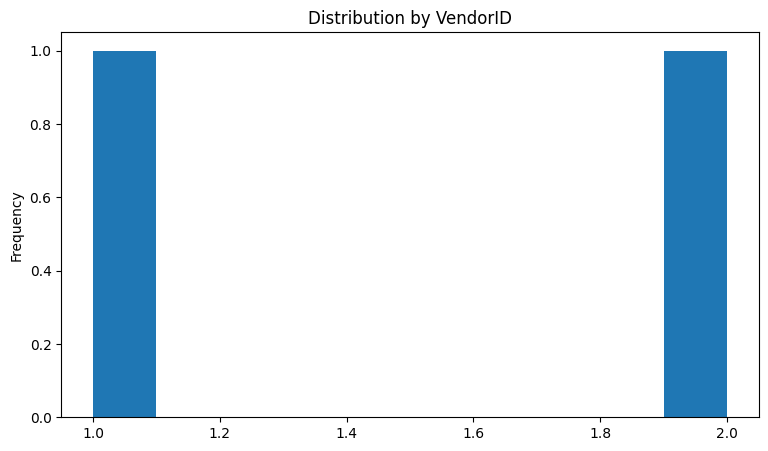

In [166]:
# count plot of VendorID
plt.figure(figsize=(9, 5))

vendors = data.groupBy(['VendorID']).count().toPandas()
vendors['VendorID'].plot(kind = 'hist', title = 'Distribution by VendorID')

In [167]:
#!pip install mplcursors

In [168]:
#Where are most of our passengers being picked up from?
data.groupBy("pickup_borough").agg(fn.count('*').alias("Number of Passengers")).show()

+--------------+--------------------+
|pickup_borough|Number of Passengers|
+--------------+--------------------+
|        Queens|              476061|
|           EWR|                  44|
|      Brooklyn|               21934|
| Staten Island|                 345|
|     Manhattan|             3817736|
|         Bronx|                5035|
+--------------+--------------------+



In [169]:
#where in Manhattan are the most pickups
data_manhattan = data.filter(data['pickup_borough'] == 'Manhattan')
manhattan_agg = data_manhattan.groupBy('pickup_zone').agg(fn.count('*').alias("Number of Passengers by Manhattan"))
manhattan_agg.sort('Number of Passengers by Manhattan', ascending = False).show(5)

+--------------------+---------------------------------+
|         pickup_zone|Number of Passengers by Manhattan|
+--------------------+---------------------------------+
|      Midtown Center|                           195025|
|Upper East Side S...|                           181448|
|Upper East Side N...|                           178313|
|Penn Station/Madi...|                           164352|
|        Midtown East|                           151237|
+--------------------+---------------------------------+
only showing top 5 rows



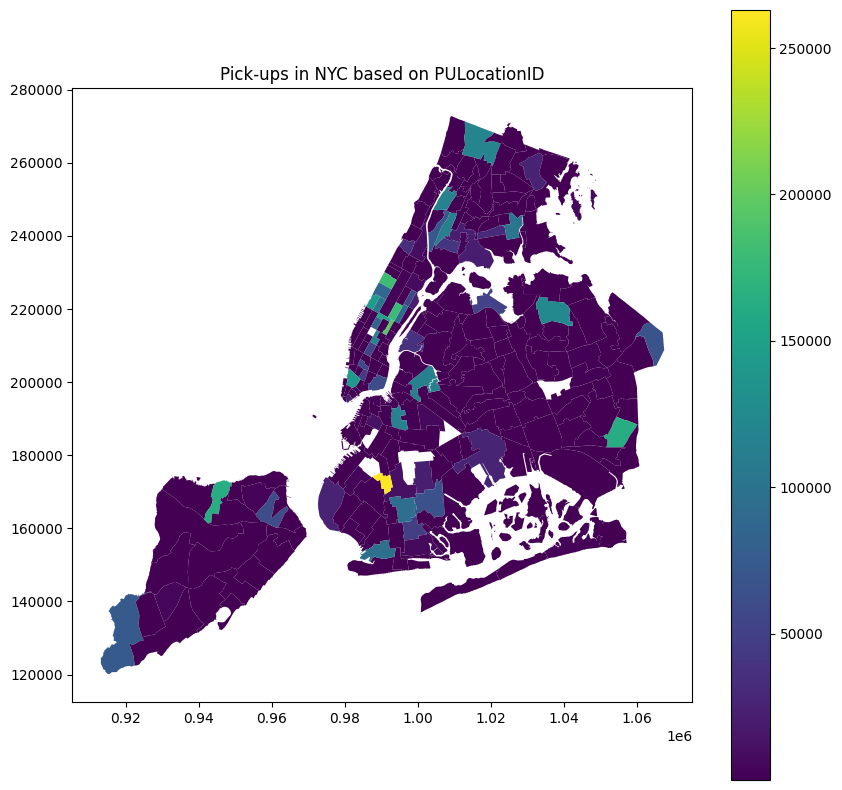

In [170]:
import geopandas as gpd
#import mplcursors

#map where colour represents the number of rides. The map is of New York City.

pickup_counts = data.groupBy("PULocationID").agg(fn.count("*").alias("count")).toPandas()
#utilizing geopandas to read the zone shape file
taxi_zones = gpd.read_file("/content/taxi_zones.shp")
taxi_zones['LocationID'] = taxi_zones.index
merged_data = taxi_zones.merge(pickup_counts, left_on="LocationID", right_on = 'PULocationID')

fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column="count", cmap="viridis", ax=ax, legend = True)
ax.set_title("Pick-ups in NYC based on PULocationID")

# texts = [f"LocationID: {loc_id}" for loc_id in merged_data["LocationID"]]
# mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(texts[sel.target.index]))

plt.show()

In [171]:
data.groupBy("dropoff_borough").agg(fn.count('*').alias("Number of Passengers")).show()
#number of dropoffs based on the drop off location

+---------------+--------------------+
|dropoff_borough|Number of Passengers|
+---------------+--------------------+
|         Queens|              256709|
|            EWR|               13217|
|       Brooklyn|              204224|
|  Staten Island|                1380|
|      Manhattan|             3816546|
|          Bronx|               29079|
+---------------+--------------------+



In [172]:
data_manhattan_dropoff = data.filter(data['dropoff_borough'] == 'Manhattan')
manhattan_agg_dropoff = data_manhattan_dropoff.groupBy('dropoff_zone').agg(fn.count('*').alias("Number of Passengers by Manhattan"))
manhattan_agg_dropoff.sort('Number of Passengers by Manhattan', ascending = False).show(5)
#where in Manhattan are the most dropoffs

+--------------------+---------------------------------+
|        dropoff_zone|Number of Passengers by Manhattan|
+--------------------+---------------------------------+
|Upper East Side N...|                           189007|
|Upper East Side S...|                           155107|
|      Midtown Center|                           151083|
|Upper West Side S...|                           124824|
| Lincoln Square East|                           121161|
+--------------------+---------------------------------+
only showing top 5 rows



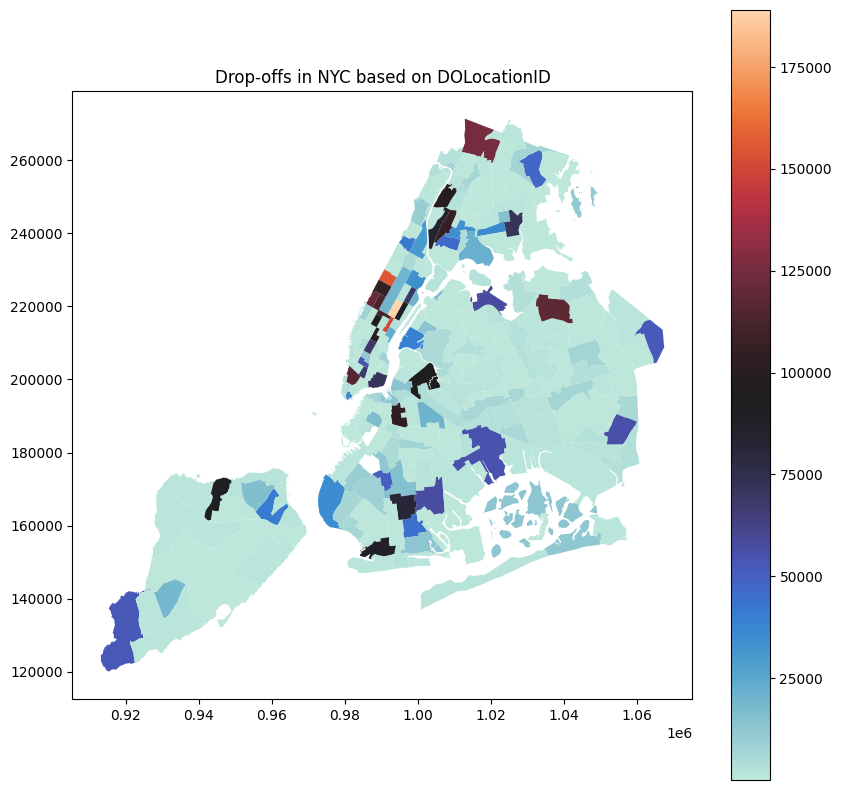

In [173]:
#map where colour represents the number of rides. The map is of New York City.
dropoff_counts = data.groupBy("DOLocationID").agg(fn.count("*").alias("count")).toPandas()
#utilizing geopandas to read the zone shape file
taxi_zones = gpd.read_file("/content/taxi_zones.shp")
taxi_zones['LocationID'] = taxi_zones.index
merged_data = taxi_zones.merge(dropoff_counts, left_on="LocationID", right_on = 'DOLocationID')

fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column="count", cmap="icefire", ax=ax, legend = True)
ax.set_title("Drop-offs in NYC based on DOLocationID")

texts = [f"LocationID: {loc_id}" for loc_id in merged_data["LocationID"]]
#mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(texts[sel.target.index]))

plt.show()

In [174]:
data.show(10)

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+-----------+--------------+------------+--------------------+---------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+------+---+-----+----+-----+----+----+----+----+-----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_time|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|dropoff_time|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|   slp|stp|visib|wdsp|mxpsd|gust| max| min|prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------

In [175]:
pip install pyspark_dist_explore

<H3> TRIP DISTANCE </H3>

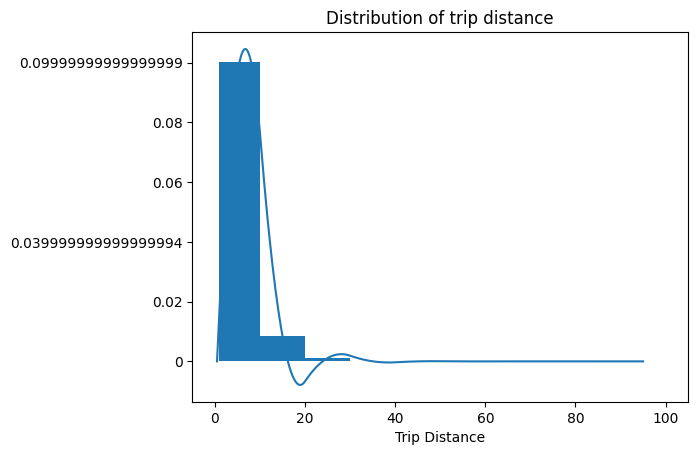

In [176]:
from pyspark_dist_explore import distplot
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
distplot(plt.gca(), data.select(fn.col('trip_distance')), bins = bins)
plt.xlabel('Trip Distance')
plt.title('Distribution of trip distance')
plt.show()
#distirbution of rides by trip distance

<H3> PASSENGER COUNT </H3>

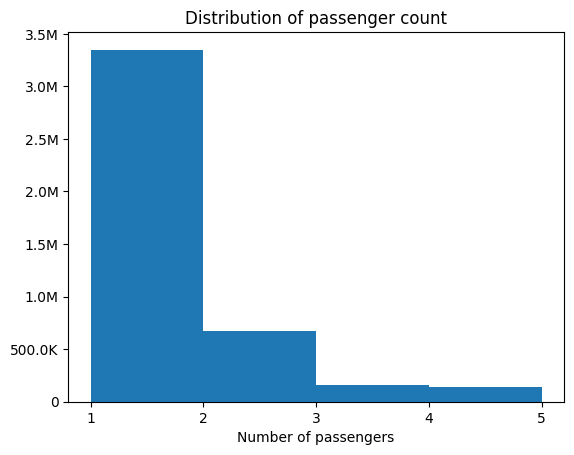

In [177]:
from pyspark_dist_explore import hist
bins = [1, 2, 3, 4, 5]
hist(plt.gca(), data.select(fn.col('passenger_count')), bins = bins)
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Number of passengers')
plt.title('Distribution of passenger count')
plt.show()
#distribution of passenger count

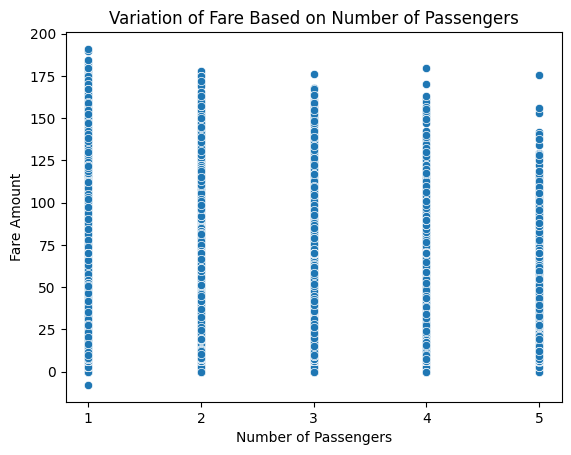

In [178]:
data_fare_passengers = data.select(['passenger_count', 'fare_amount']).toPandas()
sns.scatterplot(data=data_fare_passengers, x="passenger_count", y="fare_amount")
plt.xticks([1, 2, 3, 4, 5])
plt.title("Variation of Fare Based on Number of Passengers")
plt.xlabel("Number of Passengers")
plt.ylabel("Fare Amount")
plt.show()
#distribution of fare amount based on the passenger count

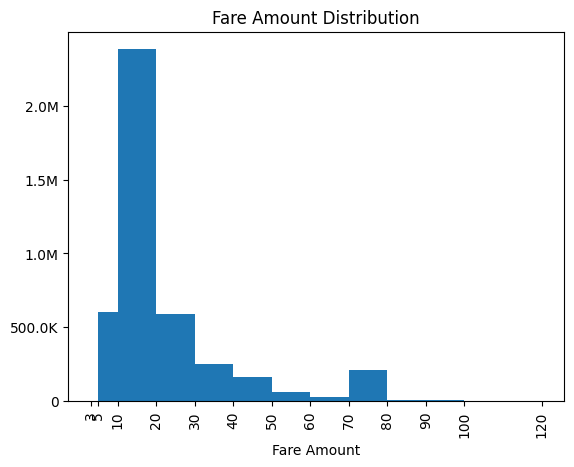

In [179]:
fare_amount_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
hist(plt.gca(), data.select(fn.col('fare_amount')), bins = fare_amount_bins)
plt.xticks(fare_amount_bins)
plt.xticks(rotation = 90)
plt.xlabel('Fare Amount')
plt.title('Fare Amount Distribution')
plt.show()
#distribution of fare amount

<H2> FARE AMOUNT DISTRIBUTION ACROSS DIFFERENT BOROUGHS </H2>

In [180]:
average_fare_across_pickup_borough = data.groupBy("pickup_borough").agg(fn.avg('fare_amount').alias("Average Amount"))
average_fare_across_pickup_borough.show()
#distribution of average fare amount across different pick up boroughs in New York City

+--------------+------------------+
|pickup_borough|    Average Amount|
+--------------+------------------+
|        Queens| 51.54851269060098|
|           EWR|            91.425|
|      Brooklyn| 27.37706665450926|
| Staten Island|58.446086956521775|
|     Manhattan|17.122175171361004|
|         Bronx| 31.37807547169787|
+--------------+------------------+



In [181]:
average_fare_across_dropoff_borough = data.groupBy("dropoff_borough").agg(fn.avg('fare_amount').alias("Average Amount"))
average_fare_across_dropoff_borough.show()
#distribution of average fare amount across different drop off boroughs in New York City

+---------------+------------------+
|dropoff_borough|    Average Amount|
+---------------+------------------+
|         Queens| 40.40398182377752|
|            EWR| 92.56177423015829|
|       Brooklyn|  40.4336565242089|
|  Staten Island| 81.89992028985488|
|      Manhattan|18.181542426060286|
|          Bronx| 45.88026135699287|
+---------------+------------------+



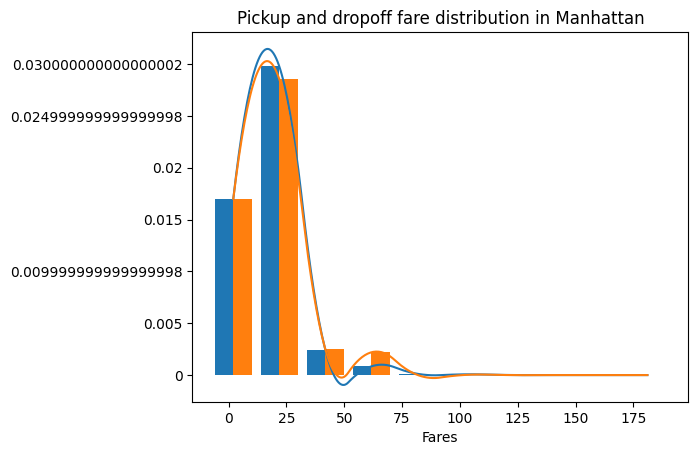

In [182]:
pickup_manhattan = data.filter(data['pickup_borough'] == 'Manhattan').select(fn.col('fare_amount'))
dropoff_manhattan = data.filter(data['dropoff_borough'] == 'Manhattan').select(fn.col('fare_amount'))
distplot(plt.gca(), [pickup_manhattan, dropoff_manhattan])
plt.xlabel('Fares')
plt.title("Pickup and dropoff fare distribution in Manhattan")
plt.show()

#pickup and dropoff fare distribution in Manhattan

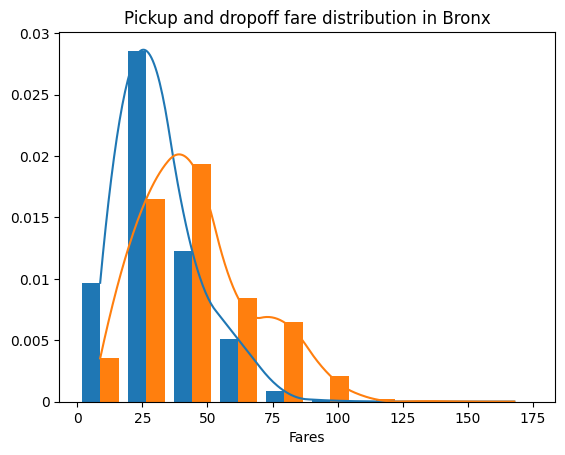

In [183]:
pickup_bronx = data.filter(data['pickup_borough'] == 'Bronx').select(fn.col('fare_amount'))
dropoff_bronx = data.filter(data['dropoff_borough'] == 'Bronx').select(fn.col('fare_amount'))
distplot(plt.gca(), [pickup_bronx, dropoff_bronx])
plt.xlabel('Fares')
#plt.gca().legend()
plt.title("Pickup and dropoff fare distribution in Bronx")
plt.show()

#pickup and dropoff fare distribution in Bronx

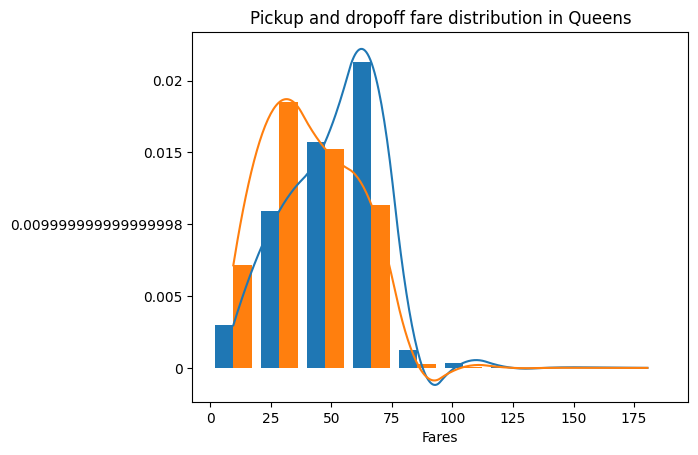

In [184]:
pickup_queens = data.filter(data['pickup_borough'] == 'Queens').select(fn.col('fare_amount'))
dropoff_queens = data.filter(data['dropoff_borough'] == 'Queens').select(fn.col('fare_amount'))
distplot(plt.gca(), [pickup_queens, dropoff_queens])

plt.xlabel('Fares')
plt.title("Pickup and dropoff fare distribution in Queens")
plt.show()

#pickup and dropoff fare distribution in Queens

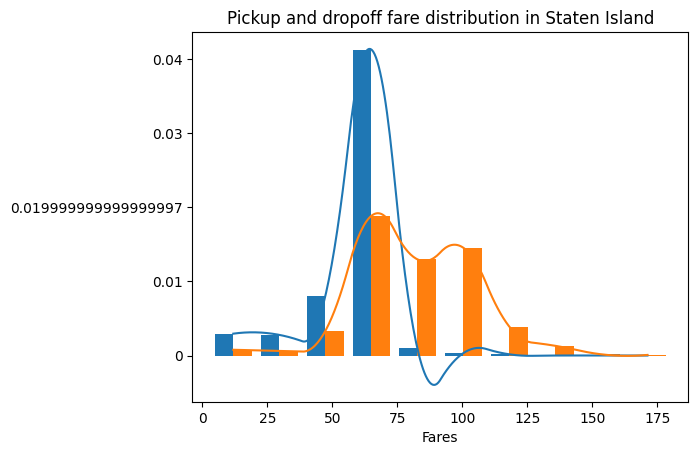

In [185]:
pickup_si = data.filter(data['pickup_borough'] == 'Staten Island').select(fn.col('fare_amount'))
dropoff_si = data.filter(data['dropoff_borough'] == 'Staten Island').select(fn.col('fare_amount'))
distplot(plt.gca(), [pickup_si, dropoff_si])
plt.xlabel('Fares')
plt.title("Pickup and dropoff fare distribution in Staten Island")
plt.show()

#pickup and dropoff fare distribution in Staten Island

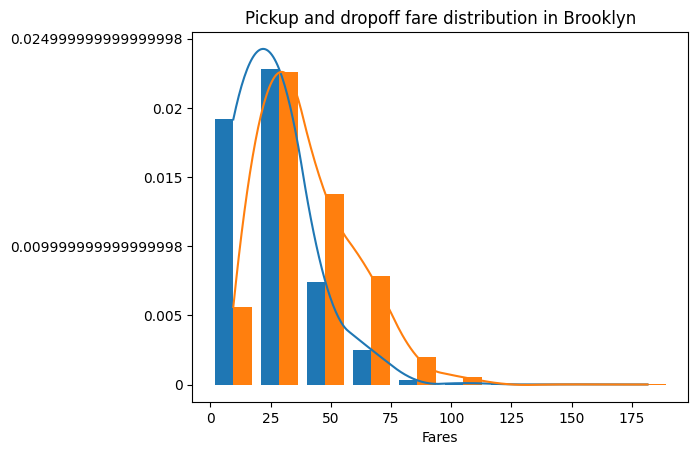

In [186]:
pickup_bklyn = data.filter(data['pickup_borough'] == 'Brooklyn').select(fn.col('fare_amount'))
dropoff_bklyn = data.filter(data['dropoff_borough'] == 'Brooklyn').select(fn.col('fare_amount'))
distplot(plt.gca(), [pickup_bklyn, dropoff_bklyn])
plt.xlabel('Fares')
plt.title("Pickup and dropoff fare distribution in Brooklyn")
plt.show()

#pickup and dropoff fare distribution in Brooklyn

<H2> FARE DISTRIBUTION ACROSS DIFFERENT AIRPORTS </H2>

In [187]:
#Average Fares when pickup is the airport
data_airport_pickup = data.filter(data['pickup_zone'].isin(['JFK Airport', 'LaGuardia Airport', 'Newark Airport']))
data_airport_dropoff = data.filter(data['dropoff_zone'].isin(['JFK Airport', 'LaGuardia Airport', 'Newark Airport']))

#filter dataset to include airport data based on pick up and drop off

In [188]:
data_airport_pickup.groupBy('pickup_zone').agg(fn.avg('fare_amount').alias("Average Airport Pickup Amount")).show()
#average fare amount when pick up is airport

+-----------------+-----------------------------+
|      pickup_zone|Average Airport Pickup Amount|
+-----------------+-----------------------------+
|   Newark Airport|                       91.425|
|LaGuardia Airport|            40.79417459003402|
|      JFK Airport|            60.44233544501098|
+-----------------+-----------------------------+



In [189]:
data_airport_dropoff.groupBy('dropoff_zone').agg(fn.avg('fare_amount').alias("Average Airport Dropoff Amount")).show()
#average fare amount when dropoff is airport

+-----------------+------------------------------+
|     dropoff_zone|Average Airport Dropoff Amount|
+-----------------+------------------------------+
|   Newark Airport|             92.56177423015829|
|LaGuardia Airport|              43.7727544737177|
|      JFK Airport|             65.20965669031767|
+-----------------+------------------------------+



Text(0.5, 1.0, 'Distribution of Fare Amount when pickup zone is JFK Airport')

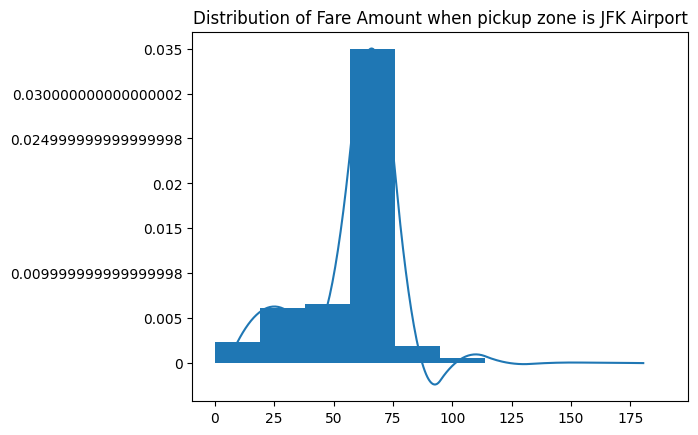

In [190]:
#Fare Distribution when pickup zone is JFK Airport
pickup_jfk = data.filter(data['pickup_zone'] == "JFK Airport")
distplot(plt.gca(), pickup_jfk.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when pickup zone is JFK Airport")

#fare amount distribution when pick up zones is JFK airport


Text(0.5, 1.0, 'Distribution of Fare Amount when dropoff zone is JFK Airport')

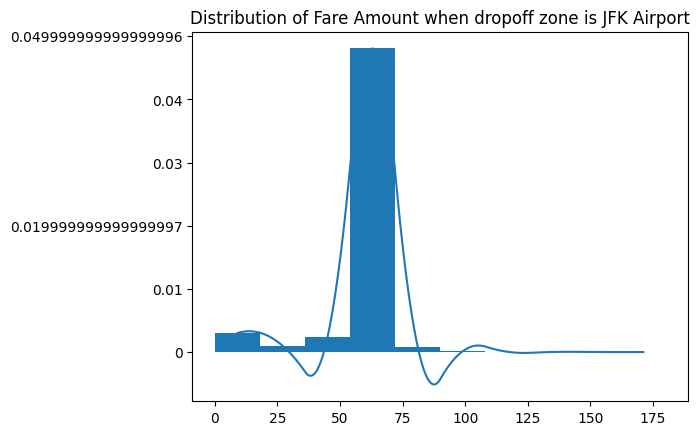

In [191]:
dropoff_jfk = data.filter(data['dropoff_zone'] == "JFK Airport")
distplot(plt.gca(), dropoff_jfk.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when dropoff zone is JFK Airport")

#fare amount distribution when dropoff zones is JFK airport


Text(0.5, 1.0, 'Distribution of Fare Amount when pickup zone is LaGuardia Airport')

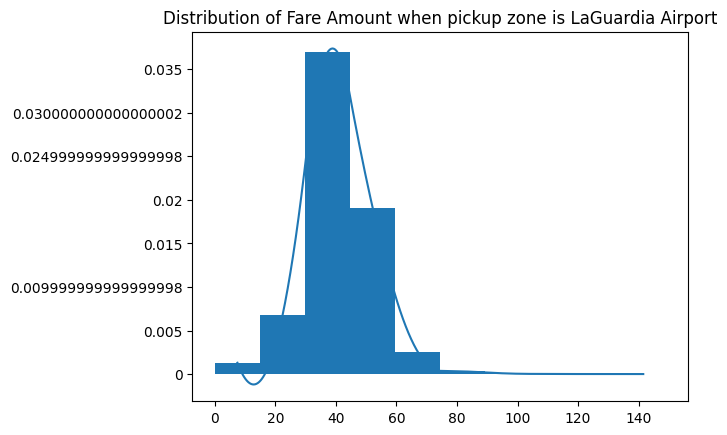

In [192]:
pickup_lga = data.filter(data['pickup_zone'] == "LaGuardia Airport")
distplot(plt.gca(), pickup_lga.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when pickup zone is LaGuardia Airport")

#fare amount distribution when pick up zones is LaGuardia airport


Text(0.5, 1.0, 'Distribution of Fare Amount when dropoff zone is LaGuardia Airport')

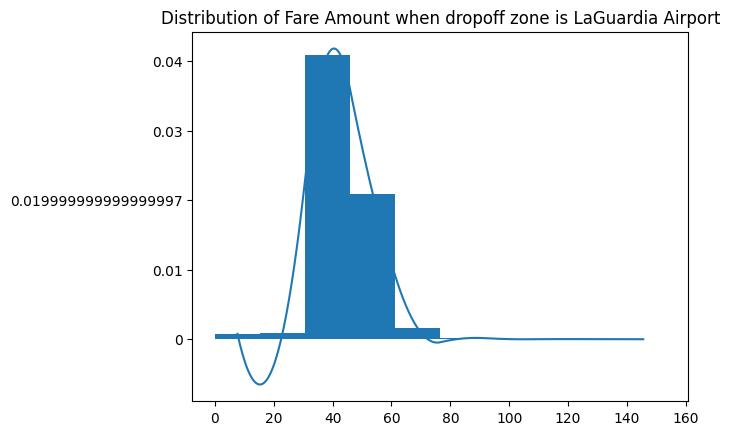

In [193]:
dropoff_lga = data.filter(data['dropoff_zone'] == "LaGuardia Airport")
distplot(plt.gca(), dropoff_lga.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when dropoff zone is LaGuardia Airport")
#fare amount distribution when dropoff zones is LaGuardia airport


Text(0.5, 1.0, 'Distribution of Fare Amount when pickup zone is Newark Airport')

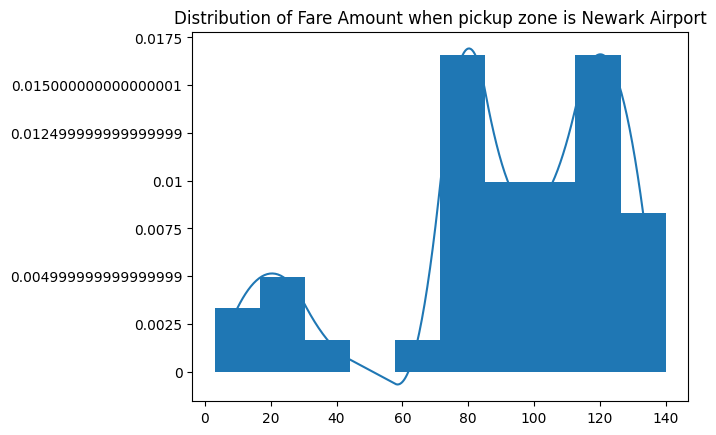

In [194]:
pickup_newark = data.filter(data['pickup_zone'] == "Newark Airport")
distplot(plt.gca(), pickup_newark.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when pickup zone is Newark Airport")

#fare amount distribution when pick up zones is EWR airport


Text(0.5, 1.0, 'Distribution of Fare Amount when dropoff zone is Newark Airport')

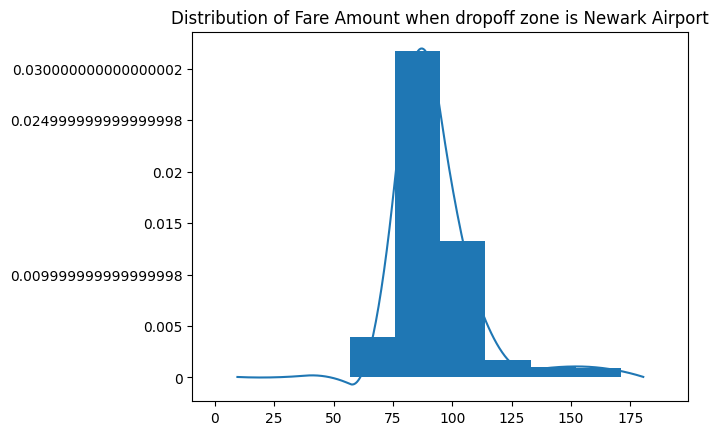

In [195]:
dropoff_newark = data.filter(data['dropoff_zone'] == "Newark Airport")
distplot(plt.gca(), dropoff_newark.select(fn.col('fare_amount')))
plt.title("Distribution of Fare Amount when dropoff zone is Newark Airport")

#fare amount distribution when drop off zones is EWR airport


<H2> TIME BASED ANALYSIS </H2>

In [196]:
time_data = data.select(['pickup_date', 'passenger_count',  'pickup_time', 'dropoff_time', 'fare_amount']).toPandas()
#select temporal columns from the dataset

In [197]:
import pandas as pd
time_data['day_name'] = pd.to_datetime(time_data['pickup_date']).dt.weekday
time_data['week'] = pd.to_datetime(time_data['pickup_date']).dt.isocalendar().week
#create two new columns, day_name and week which contain day number in week and week number in year

In [198]:
time_data.tail()

,pickup_date,passenger_count,pickup_time,dropoff_time,fare_amount,day_name,week
4321150,2023-02-28,1.0,23:33:28,23:49:26,35.2,1,9
4321151,2023-02-28,1.0,23:22:35,23:31:35,11.4,1,9
4321152,2023-02-28,1.0,23:47:42,23:54:17,10.0,1,9
4321153,2023-02-28,2.0,23:10:57,23:17:52,10.7,1,9
4321154,2023-02-28,1.0,23:09:54,23:23:41,16.3,1,9


In [199]:
time_data['week'] = time_data['week'].replace(52, 1)
#replace 52 by 1 since, the 1st of January and last week of December fall in the same week

In [200]:
pickup_counts = time_data.groupby('week').count().reset_index()
#pick ups by week

In [201]:
pickup_count_data = pickup_counts[['week', 'passenger_count']]
pickup_count_data.tail()

,week,passenger_count
4,5,496411
5,6,538839
6,7,530052
7,8,527021
8,9,137676


Text(0, 0.5, 'Number of Passengers')

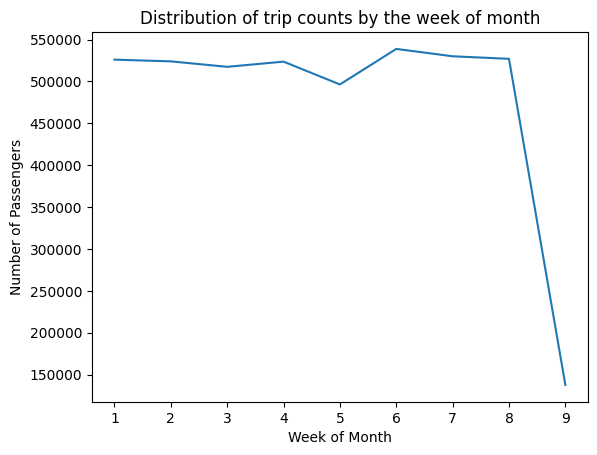

In [202]:
sns.lineplot(x = 'week', y = 'passenger_count', data = pickup_count_data)
plt.title("Distribution of trip counts by the week of month")
plt.xlabel("Week of Month")
plt.ylabel("Number of Passengers")
#distribution of passenger count by the week number

In [203]:
#trip counts based on the day of week across both the months
day_counts = time_data.groupby('day_name').count().reset_index()

In [204]:
day_names = {0:'Sunday', 1:'Monday', 2:'Tuesday', 3: 'Wednesday', 4:'Thursday', 5:'Friday', 6:'Sunday'}
day_counts['day_name_word'] = day_counts['day_name'].map(day_names)

#map dictionary to get the names of the days

<ipython-input-205-ac3bd4633373>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'day_name_word', y = 'passenger_count', data = day_counts, palette = 'pastel')


Text(0, 0.5, 'Number of Passengers')

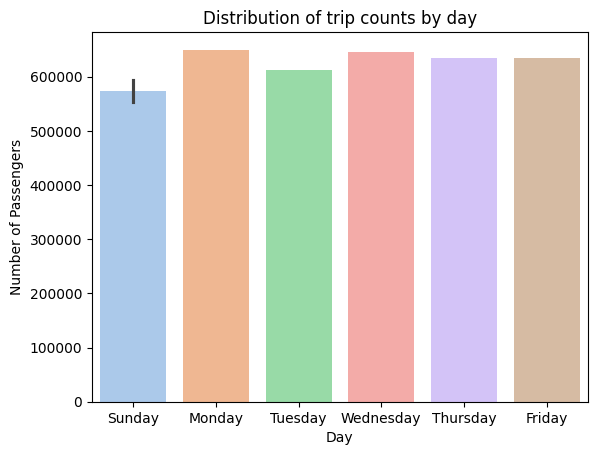

In [205]:
sns.barplot(x = 'day_name_word', y = 'passenger_count', data = day_counts, palette = 'pastel')
plt.title("Distribution of trip counts by day")
plt.xlabel("Day")
plt.ylabel("Number of Passengers")

#distribution of number of trips by day of week

In [206]:
time_fare = data.select(['pickup_date', 'fare_amount']).toPandas()

In [207]:
time_fare['day_name'] = pd.to_datetime(time_fare['pickup_date']).dt.weekday
time_fare['week'] = pd.to_datetime(time_fare['pickup_date']).dt.isocalendar().week
time_fare['week'] = time_fare['week'].replace(52, 1)
time_fare['day_name_word'] = time_fare['day_name'].map(day_names)

In [208]:
time_fare.head()

,pickup_date,fare_amount,day_name,week,day_name_word
0,2023-01-01,7.9,6,1,Sunday
1,2023-01-01,14.9,6,1,Sunday
2,2023-01-01,11.4,6,1,Sunday
3,2023-01-01,12.8,6,1,Sunday
4,2023-01-01,12.1,6,1,Sunday


Text(0.5, 1.0, 'Average Fare Amount by week of year')

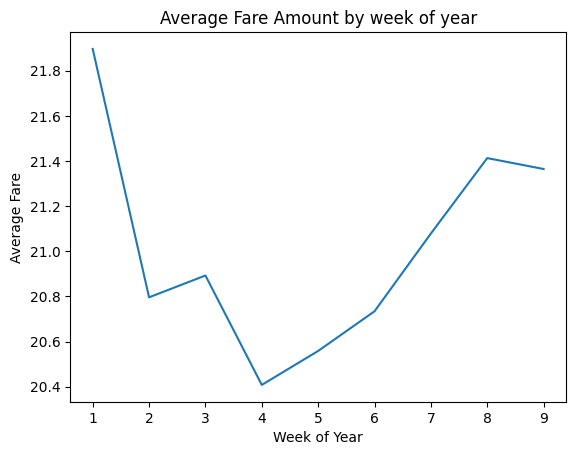

In [209]:
avg_fare = time_fare.groupby('week')['fare_amount'].mean().reset_index()
sns.lineplot(x = 'week', y = 'fare_amount', data = avg_fare)
plt.xlabel("Week of Year")
plt.ylabel("Average Fare")
plt.title("Average Fare Amount by week of year")

#average fare amount by week of year

Text(0.5, 1.0, 'Average Fare Amount by day of week')

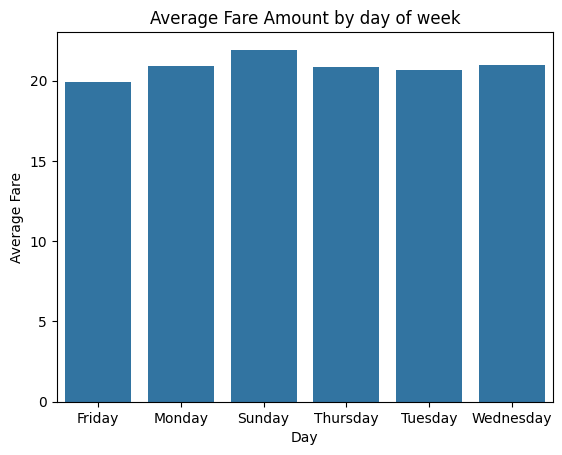

In [210]:
avg_fare = time_fare.groupby('day_name_word')['fare_amount'].mean().reset_index()
sns.barplot(x = 'day_name_word', y = 'fare_amount', data = avg_fare)
plt.xlabel("Day")
plt.ylabel("Average Fare")
plt.title("Average Fare Amount by day of week")

#average fare amount by day of week

<H2> WEATHER BASED ANALYSIS </H2>

In [211]:
weather_analysis = data.select('pickup_date', 'passenger_count', 'trip_distance', 'fare_amount', 'temp', 'visib', 'gust', 'prcp',
    fn.col('fog').cast('int'),
    fn.col('rain_drizzle').cast('int'),
    fn.col('snow_ice_pellets').cast('int'),
    fn.col('hail').cast('int'),
    fn.col('thunder').cast('int')
)
weather_analysis.registerTempTable("weather_analysis")

#select weather based columns and create a temp table

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [212]:
precipitation_query = """ select pickup_date, avg(temp) as average_temperature,
avg(prcp) as average_precipitation, avg(fare_amount) as average_fare,
count(*) as num_rides
from weather_analysis
group by pickup_date"""
#run the query and store the results in a dataframe
precip_data = spark.sql(precipitation_query).toPandas()

#create a query with the average temperature, precipitation, fare amount and number of rides

In [213]:
precip_data.head()

,pickup_date,average_temperature,average_precipitation,average_fare,num_rides
0,2023-01-01,52.4,0.28,23.911867,56918
1,2023-01-02,52.0,0.00,24.801459,49176
2,2023-01-28,42.7,0.00,19.363777,82022
3,2023-01-11,37.8,0.00,19.958445,76175
4,2023-02-01,32.1,0.05,20.040956,76840


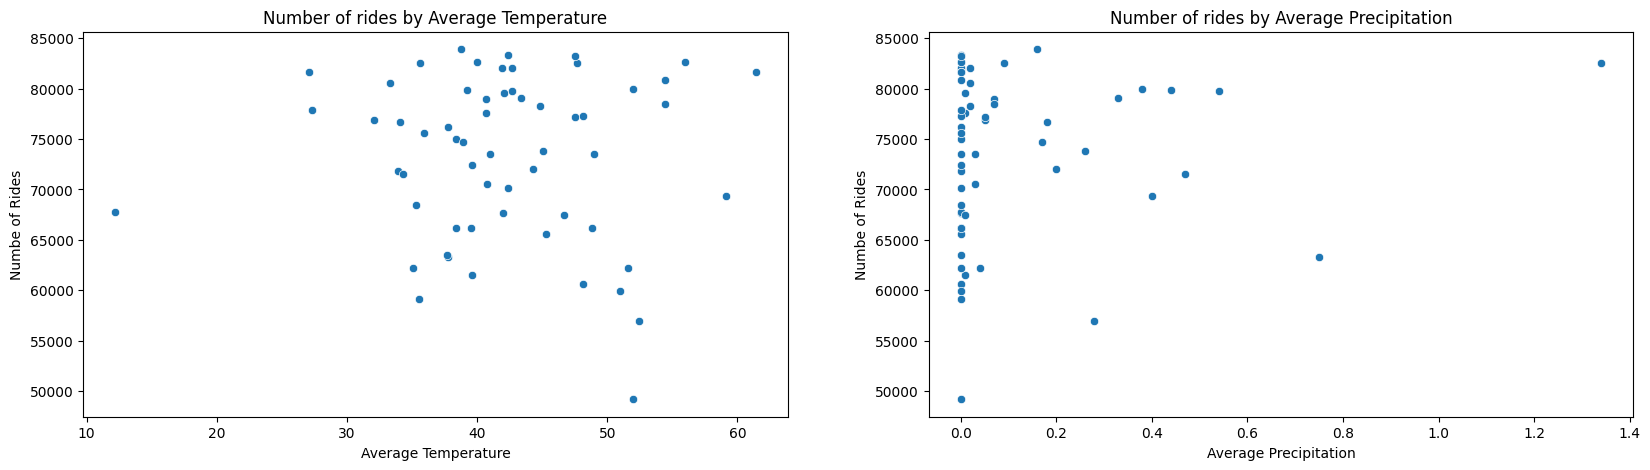

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.scatterplot(x = 'average_temperature', y = 'num_rides', data  = precip_data, ax = ax[0])
# plt.title("Variation of the number of rides with the average temperature")
# plt.ylabel("Number of rides")
# plt.xlabel("Average Temperature")
ax[0].set_xlabel("Average Temperature")
ax[0].set_ylabel("Numbe of Rides")
ax[0].set_title("Number of rides by Average Temperature")

sns.scatterplot(x = 'average_precipitation', y = 'num_rides', data  = precip_data, ax = ax[1])
plt.title("Variation of the number of rides with the average precipitation (Rainfall)")
# plt.ylabel("Number of rides")
# plt.xlabel("Average Precipitation")

ax[1].set_xlabel("Average Precipitation")
ax[1].set_ylabel("Numbe of Rides")
ax[1].set_title("Number of rides by Average Precipitation")
plt.show()

#plot graphs of number of rides by average temperature and average precipitation

Text(0.5, 23.52222222222222, 'Average Temperature')

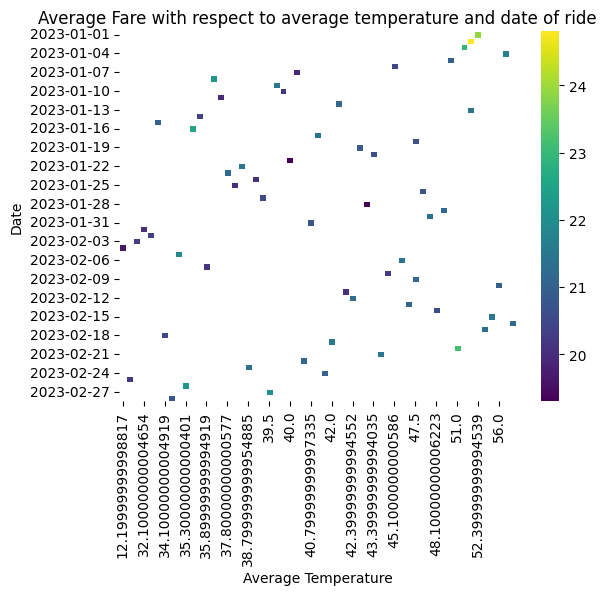

In [215]:
avg_fare_by_date_temp = precip_data.groupby(['pickup_date', 'average_temperature'])['average_fare'].mean().reset_index()
heatmap = avg_fare_by_date_temp.pivot(index='pickup_date', columns='average_temperature', values='average_fare')
sns.heatmap(heatmap, cmap='viridis', linewidths=.5)
plt.title("Average Fare with respect to average temperature and date of ride")
plt.ylabel("Date")
plt.xlabel("Average Temperature")

#plot graphs of average price by the date and average temperature

Text(0.5, 23.52222222222222, 'Average Precipitation')

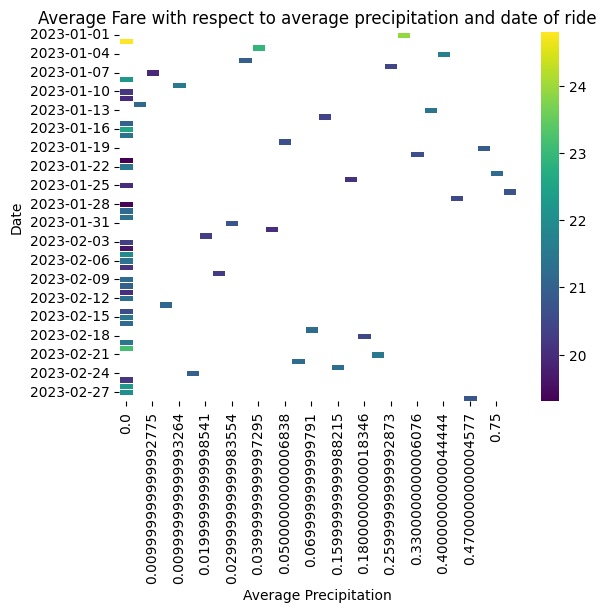

In [216]:
avg_fare_by_date_precip = precip_data.groupby(['pickup_date', 'average_precipitation'])['average_fare'].mean().reset_index()
heatmap_precip = avg_fare_by_date_precip.pivot(index='pickup_date', columns='average_precipitation', values='average_fare')
sns.heatmap(heatmap_precip, cmap='viridis', linewidths=.5)
plt.title("Average Fare with respect to average precipitation and date of ride")
plt.ylabel("Date")
plt.xlabel("Average Precipitation")

#plot graphs of average price by the date and average precipitation

In [217]:
precip_data['pickup_date'] = pd.to_datetime(precip_data['pickup_date'])
precip_data['week_number'] = precip_data['pickup_date'].dt.isocalendar().week
precip_data['week_number'] = precip_data['week_number'].replace(52, 1)

#create additional columns

<H1> **ML MODELLING** </H1>

In [220]:
data = data.select('passenger_count', 'trip_distance', 'pickup_borough',
                   'dropoff_borough', 'fare_amount', 'payment_type', 'temp', 'visib',
                    'gust', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder'
                   )

#select the columns to be used in ML modelling

In [221]:
data.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- temp: double (nullable = true)
 |-- visib: double (nullable = true)
 |-- gust: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- fog: string (nullable = true)
 |-- rain_drizzle: string (nullable = true)
 |-- snow_ice_pellets: string (nullable = true)
 |-- hail: string (nullable = true)
 |-- thunder: string (nullable = true)



In [222]:
data.show(10)

+---------------+-------------+--------------+---------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+
|passenger_count|trip_distance|pickup_borough|dropoff_borough|fare_amount|payment_type|temp|visib|gust|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|
+---------------+-------------+--------------+---------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+
|            1.0|          1.1|     Manhattan|      Manhattan|        7.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|
|            1.0|         2.51|     Manhattan|      Manhattan|       14.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|
|            1.0|         1.43|     Manhattan|      Manhattan|       11.4|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|
|            1.0|         1.84|     Manhattan|      Manhattan|  

In [223]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
#using string indexer to transform the categorical variables
indexer_pickup = StringIndexer(inputCol = 'pickup_borough', outputCol = 'pickup_borough_indexed')
indexer_dropoff = StringIndexer(inputCol = 'dropoff_borough', outputCol = 'dropoff_borough_indexed')
data = indexer_pickup.fit(data).transform(data)
data = indexer_dropoff.fit(data).transform(data)

#Now, use one hot encoding to transform these columns
one_hot_encoding  = OneHotEncoder(inputCols = ['pickup_borough_indexed', 'dropoff_borough_indexed'], outputCols = ['ohe_pickup_borough', 'ohe_dropoff_borough'])
data = one_hot_encoding.fit(data).transform(data)
data = data.drop('pickup_borough', 'pickup_borough_indexed', 'dropoff_borough', 'dropoff_borough_indexed')

In [224]:
data.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- temp: double (nullable = true)
 |-- visib: double (nullable = true)
 |-- gust: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- fog: string (nullable = true)
 |-- rain_drizzle: string (nullable = true)
 |-- snow_ice_pellets: string (nullable = true)
 |-- hail: string (nullable = true)
 |-- thunder: string (nullable = true)
 |-- ohe_pickup_borough: vector (nullable = true)
 |-- ohe_dropoff_borough: vector (nullable = true)



In [225]:
data = data.select(
    'passenger_count', 'trip_distance', 'fare_amount', 'payment_type', 'temp',
    'visib', 'gust', 'prcp',
    fn.col('fog').cast('int'),
    fn.col('rain_drizzle').cast('int'),
    fn.col('snow_ice_pellets').cast('int'),
    fn.col('hail').cast('int'),
    fn.col('thunder').cast('int'),
    'ohe_pickup_borough',
    'ohe_dropoff_borough'
)

data.printSchema()

#cast string columns to integer

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- temp: double (nullable = true)
 |-- visib: double (nullable = true)
 |-- gust: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- fog: integer (nullable = true)
 |-- rain_drizzle: integer (nullable = true)
 |-- snow_ice_pellets: integer (nullable = true)
 |-- hail: integer (nullable = true)
 |-- thunder: integer (nullable = true)
 |-- ohe_pickup_borough: vector (nullable = true)
 |-- ohe_dropoff_borough: vector (nullable = true)



In [226]:
data.show(10)

+---------------+-------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+------------------+-------------------+
|passenger_count|trip_distance|fare_amount|payment_type|temp|visib|gust|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|ohe_pickup_borough|ohe_dropoff_borough|
+---------------+-------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+------------------+-------------------+
|            1.0|          1.1|        7.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|
|            1.0|         2.51|       14.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|
|            1.0|         1.43|       11.4|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|
|            1.0

In [229]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
#use Vector Assembler to assemble the features to a single vector
assembler = VectorAssembler(inputCols = ['passenger_count', 'trip_distance', 'payment_type', 'temp', 'visib', 'gust', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder', 'ohe_pickup_borough', 'ohe_dropoff_borough'], outputCol='features')
#scale the feature vector to ensure similar scale across all features
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
#create a pipeline with assembler and scaler
pipeline = Pipeline(stages = [assembler, scaler])
#fit data on pipeline
pipeline_fit = pipeline.fit(data)
#transform data using the pipeline
data_transformed = pipeline_fit.transform(data)

In [230]:
data_transformed.show(10)

+---------------+-------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+------------------+-------------------+--------------------+--------------------+
|passenger_count|trip_distance|fare_amount|payment_type|temp|visib|gust|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|ohe_pickup_borough|ohe_dropoff_borough|            features|     scaled_features|
+---------------+-------------+-----------+------------+----+-----+----+----+---+------------+----------------+----+-------+------------------+-------------------+--------------------+--------------------+
|            1.0|          1.1|        7.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|(22,[0,1,2,3,4,5,...|(22,[0,1,2,3,4,5,...|
|            1.0|         2.51|       14.9|           1|52.4|  8.1|15.0|0.28|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|(22,[0,1,2,3,

<H1> TRAINING DATA AND TESTING DATA </H1>

In [231]:
training_data, testing_data = data_transformed.randomSplit([0.8, 0.2], seed = 98)
print("The number of rows in training set are ", training_data.count())
print("The number of rows in testing set are ", testing_data.count())
#split data into train and test  at 80:20 ratio

The number of rows in training set are  3456507
The number of rows in testing set are  864648


<H3> LINEAR REGRESSION </H3>

In [232]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
#run linear regression with 50 max iterations and a normal solver
#fare amount is our dependent variable
lr_model = LinearRegression(maxIter = 50, solver = "normal", labelCol = 'fare_amount', featuresCol = 'scaled_features')

In [233]:
model_1 = lr_model.fit(training_data)
#fit data on model and tranform it
model_1.transform(training_data).show(5)

+---------------+-------------+-----------+------------+----+-----+-----+----+---+------------+----------------+----+-------+------------------+-------------------+--------------------+--------------------+------------------+
|passenger_count|trip_distance|fare_amount|payment_type|temp|visib| gust|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|ohe_pickup_borough|ohe_dropoff_borough|            features|     scaled_features|        prediction|
+---------------+-------------+-----------+------------+----+-----+-----+----+---+------------+----------------+----+-------+------------------+-------------------+--------------------+--------------------+------------------+
|            1.0|          1.0|        3.0|           1|38.4|  9.6|999.9| 0.0|  0|           1|               0|   0|      0|     (5,[0],[1.0])|      (5,[0],[1.0])|(22,[0,1,2,3,4,5,...|(22,[0,1,2,3,4,5,...|10.225149708458195|
|            1.0|          1.0|        3.0|           1|42.7| 10.0| 28.0| 0.0|  0|           0| 

In [234]:
mse_evaluate = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
lr_test_rmse = mse_evaluate.evaluate(model_1.transform(testing_data))
#evaluate the model using RMSE

In [235]:
print(f'Linear regression test RMSE: {lr_test_rmse:.2f}')
#print rmse

Linear regression test RMSE: 3.75


<H3> RANDOM FOREST REGRESSOR </H3>

In [236]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

#create a random forest regressor model
randomforest_model = RandomForestRegressor(labelCol="fare_amount", featuresCol= "scaled_features")
#fit data on model
rf_model = randomforest_model.fit(training_data)

In [237]:
model_predictions = rf_model.transform(testing_data)
#transform data on random forest regressor model

In [243]:
rf_test_rmse = mse_evaluate.evaluate(model_predictions)
#evaluate model

In [244]:
print(f'Random Forest Regressor test RMSE: {rf_test_rmse:.2f}')
#print RMSE

Random Forest Regressor test RMSE: 4.47


<H3> DECISION TREE REGRESSOR </H3>

In [245]:
from pyspark.ml.regression import DecisionTreeRegressor
#build a decision tree model
decision_tree = DecisionTreeRegressor(labelCol="fare_amount", featuresCol= "scaled_features")

In [246]:
dt_model = decision_tree.fit(training_data)
#fit data on decision tree model
dt_model_pred = dt_model.transform(testing_data)
#transform data on model

In [248]:
dt_test_rmse = mse_evaluate.evaluate(dt_model_pred)
print(f'Decision TreeRegressor test RMSE: {dt_test_rmse:.2f}')
#evaluate the model and print out RMSE

Decision TreeRegressor test RMSE: 3.65
